<a href="https://colab.research.google.com/github/kannavdhawan/fake_news_challenge/blob/master/Bi_lstm_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries/




In [ ]:
  
import numpy as np
import pandas as pd
import os
import re
import csv
from IPython.display import Image
import pydot
from string import punctuation

# gensim dependencies
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# keras dependencies 

from keras.preprocessing.text import text_to_word_sequence as word_seq
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Input, Dense,  Activation, Bidirectional, LSTM, Embedding, Dropout, BatchNormalization
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model 
from keras.utils import np_utils

from keras import optimizers
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

import tensorflow as tf


# nltk 

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

%matplotlib inline
from matplotlib import pyplot as plt

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Defining the hyperparameters of the neural network we are constructing

In [ ]:
#Defining hyperparameters
Maximum_length= 128     # maximum lenth to be padded
Dimensions_embedding = 50   # as per glove 
seed = 1337 # reproducing the same results
np.random.seed(seed)   ### Using seed to get same results in every run


# Loading the train bodies and test bodies from the dataset

In [ ]:
# loading the articles .csv files in dataset(both in train and competition set )


# loading body 
body_train = pd.read_csv('/content/drive/My Drive/641/'+'train_bodies.csv')
body_test = pd.read_csv('/content/drive/My Drive/641/'+'competition_test_bodies.csv')


### Loading the train stances and test stances from the dataset

# training data is being loaded(stances)
stances_train = pd.read_csv('/content/drive/My Drive/641/' + 'train_stances.csv')
# testing data is being loaded(stances)
stances_test = pd.read_csv('/content/drive/My Drive/641/'  + 'competition_test_stances.csv')

# checking 
print(body_train.tail(3))
print(body_test.tail(3))

      Body ID                                        articleBody
1680     2530  More than 200 schoolgirls were kidnapped in Ap...
1681     2531  A Guantanamo Bay prisoner released last year a...
1682     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...
     Body ID                                        articleBody
901     2584  Millions may lose coverage next year if Congre...
902     2585  Come November, the grim trudge across the incr...
903     2586  Remember how much Republicans wanted to repeal...


In [ ]:
print("Checking dims  body train : ", body_train.shape)
print("Checking dims body test : ", body_test.shape)
print("Checking dims stances train : ", stances_train.shape)
print("Checking dims stances test: ", stances_test.shape)

Checking dims  body train :  (1683, 2)
Checking dims body test :  (904, 2)
Checking dims stances train :  (49972, 3)
Checking dims stances test:  (25413, 3)


In [ ]:
stances_test.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


### Replacing the stances with respective integer labels

In [ ]:
def change_labels(stances_train,stances_test):
    # Replace the string stances with relative integer counterparts
    stances_train.replace('unrelated',1,True)
    stances_train.replace('agree',2,True)
    stances_train.replace('disagree',3,True)
    stances_train.replace('discuss',4,True)

    stances_test.replace('unrelated',1,True)
    stances_test.replace('agree',2,True)
    stances_test.replace('disagree',3,True)
    stances_test.replace('discuss',4,True)
    return stances_train,stances_test

In [ ]:
stances_train,stances_test=change_labels(stances_train,stances_test)

stances_test.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,1
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,1
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,1
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,1
4,Argentina's President Adopts Boy to End Werewo...,37,1


### Making the combined training and testing dataframes  using dataframe.join ()method

In [ ]:
# combine bodies dataframe with stances dataframe for both train and competition test set
full_train = stances_train.join(body_train.set_index('Body ID'), on='Body ID')
full_test = stances_test.join(body_test.set_index('Body ID'), on='Body ID')

In [ ]:
print(full_train.shape)
print(full_test.shape)

(49972, 4)
(25413, 4)


In [ ]:
full_train.head(3)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,2,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,1,30-year-old Moscow resident was hospitalized w...


In [ ]:
print("Unique body ids in final df :",len(full_train['Body ID'].unique()))

Unique body ids in final df : 1683


In [ ]:
full_train.head(5)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,2,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,1,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,1,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,3,"Fear not arachnophobes, the story of Bunbury's..."


### Here we are constructing text_to_word_sequence using keras function to form List of lists of  tokenized headlines for both train and test headings and bodies(articles)

In [ ]:
# Here we are constructing text_to_word_sequence(keras functions)(Lists of lists)
def gen_tokens(dataset):
    headline = [word_seq(headline) for headline in dataset['Headline']]
    body = [word_seq(body) for body in dataset['articleBody']]
    return headline, body 

In [ ]:
tokens_headline_train, tokens_body_train=gen_tokens(full_train)
tokens_headline_test, tokens_body_test=gen_tokens(full_test)

print(tokens_headline_train[0])
print(len(tokens_headline_train))

['police', 'find', 'mass', 'graves', 'with', 'at', 'least', "'15", "bodies'", 'near', 'mexico', 'town', 'where', '43', 'students', 'disappeared', 'after', 'police', 'clash']
49972


###  Adding all the train sequences together

In [ ]:
def gen_data_for_fit_on_texts(tokens_headline_train,tokens_body_train):
    sequences= []
    for i in range(len(tokens_headline_train)):
        sequences.append(tokens_headline_train[i])
    for i in range(len(tokens_body_train)):
        sequences.append(tokens_body_train[i])
    return sequences

In [ ]:
sequences=gen_data_for_fit_on_texts(tokens_headline_train,tokens_body_train)
sequences[0]  # headline form train set 

['police',
 'find',
 'mass',
 'graves',
 'with',
 'at',
 'least',
 "'15",
 "bodies'",
 'near',
 'mexico',
 'town',
 'where',
 '43',
 'students',
 'disappeared',
 'after',
 'police',
 'clash']

### Construct the keras tokenizer and apply fit on text function of it on word sequences generated

In [ ]:
def gen_tokenize(sequences):
    # using keras tokenizer and filter_list
    tokenizer = Tokenizer(filters= '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts([seq for seq in sequences])

    print("vocabulary size :", len(tokenizer.word_index))
    return tokenizer

In [ ]:
tokenizer=gen_tokenize(sequences)

vocabulary size : 27873


### list of list of tokens
- tokens_headline_train
- tokens_body_train
- tokens_headline_test 
- tokens_body_test

In [ ]:
def concat_head_body(headline,body):
    #Here we are combining headlines and bodies together
    combined_head_body=[]
    
    combined_head_body = [list(i) for i in headline]
    for i in range(len(headline)):
        # extend() modifies the original list and does not return any value
        combined_head_body[i].extend(body[i]) 
    return combined_head_body

In [ ]:
combined_head_body_train=concat_head_body(tokens_headline_train,tokens_body_train)
combined_head_body_test=concat_head_body(tokens_headline_test,tokens_body_test)

In [ ]:
# combined_head_body_train[0]

In [ ]:
print(len(combined_head_body_train))
print(len(combined_head_body_train[0]))     # diffent length 
print(len(combined_head_body_train[1]))     # different length

49972
216
445


### Using keras tokenizer for text to sequence and pad sequence generation for train dataset and test dataset
### Forming train labels  for the combined train data frame

In [ ]:
def generate_padded_dataset(combined_head_body,tokenizer,df):
    # Now we will take max length to lower the length of sentences we have to deal with. 
    #It is very important beacuse as the length of sentences increases, our ability to handle many of those senetences decreases
    # Convert the sequence of words to sequnce of indices
    # maximum length is 128 ..
    X = tokenizer.texts_to_sequences([' '.join(seq[:]) for seq in combined_head_body])
    X = pad_sequences(X, maxlen=128, padding='post', truncating='post')
    #target label from combined data frame
    y = df['Stance']
    return X, y

In [ ]:
X_train,y_train=generate_padded_dataset(combined_head_body_train,tokenizer,full_train)
X_test,y_test=generate_padded_dataset(combined_head_body_test,tokenizer,full_test)

In [ ]:
X_train

array([[  90,  407,  712, ...,    8,    2,  557],
       [1060,    4, 9286, ...,  161,    4,    1],
       [ 639,  464, 7035, ..., 2438,   35,  341],
       ...,
       [ 735,  110,  210, ...,    0,    0,    0],
       [  93, 5578, 1650, ...,   84,  289,    0],
       [ 259,  241,    5, ..., 3962, 3122,    6]], dtype=int32)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test[0])

(49972, 128)
(49972,)
(25413, 128)
(25413,)
1


# --------


### Encoding the training labels and then converting them into one-hot-encoding form

In [ ]:
y_train

0        1
1        2
2        1
3        1
4        3
        ..
49967    1
49968    1
49969    2
49970    4
49971    1
Name: Stance, Length: 49972, dtype: int64

In [ ]:
# Encoding labels(train)
# Label Encoder is used to normalize the labels between 0 and N-Classes-1
train_encoder = LabelEncoder()
y_train_encoded=train_encoder.fit_transform(y_train)
print(y_train_encoded)
# Converting labels to one-hot-encoding
y_train = np_utils.to_categorical(y_train_encoded)

[0 1 0 ... 1 3 0]


In [ ]:
y_train

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

### Encoding the testing labels and then converting them into one-hot-encoding form

In [ ]:
# # Encoding labels(train)
# Label Encoder is used to normalize the labels between 0 and N-Classes-1
test_encoder = LabelEncoder()# predefined function taken from sklearn
y_test_encoded=test_encoder.fit_transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(y_test_encoded)

In [ ]:
y_test.shape

(25413, 4)

## splitting the dataset

In [ ]:
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train, random_state=42, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(39977, 128)
(39977, 4)
(9995, 128)
(9995, 4)
(25413, 128)
(25413, 4)


###  Embedding matrix using glove and the word_index dict


### Defining the data directory where we have  train and test dataset 
### Defing the path where we have GloVe pretrained embedding 

In [ ]:
# Twitter glove with 50d
# converting the glove to word2vec 
glove2word2vec('/content/drive/My Drive/641/glove.twitter.27B.50d.txt', '/content/drive/My Drive/641/glove.50d.txt.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1193514, 50)

###  Here we are creating embedding matrix using our vocabulary we calculated. If the word is not in the GloVe, we take its vector as comprised of zeros

In [ ]:
# embeddings
w2v_vectors= gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/641/glove.50d.txt.word2vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
w2v_vectors['the'].shape

(50,)

In [ ]:
# Here we are creating embedding matrix using our vocabulary we calculated. If the word is not in the GloVe, we take its vector as comprised of zeros

found_count =0
not_found_count = 0
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, Dimensions_embedding))
for word, i in tokenizer.word_index.items():
    try:
        e_vector= w2v_vectors[word]
    except KeyError:
        e_vector=None
    if e_vector is not None:          # If word exists in the Glove embedding we are using

        embedding_matrix[i] = e_vector
        found_count+=1
    else:
        not_found_count+=1

In [ ]:
print("Found_count:",found_count)
print("Not found count:",not_found_count)

Found_count: 20066
Not found count: 7807


## Model 1 - Bi lstm

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=Dimensions_embedding,
                          weights = [embedding_matrix], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
model.add(Bidirectional(LSTM(128, return_sequences=True, name='Bidrectional_lstm_layer_1')))
model.add(Bidirectional(LSTM(64, return_sequences=False, name='Bidrectional_lstm_layer_2')))

model.add(Dropout(rate=0.4, name='dropout_1'))
model.add(Dense(32,activation='relu', name='Dense_layer'))

model.add(Dropout(rate=0.2, name='dropout_2'))

model.add(Dense(4, activation='softmax', name='output_layer'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                

### Compiling the model

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
              metrics=['accuracy'])

### Training of the Bidirectional LSTM Model

In [ ]:
# get the training history of the model in each epoch
model_h = model.fit(X_train, y_train,batch_size=256,epochs=35,validation_data=(X_val, y_val))

Train on 39977 samples, validate on 9995 samples
Epoch 1/35
39977/39977 [==============================] - 192s 5ms/step - loss: 0.8085 - accuracy: 0.7254 - val_loss: 0.7174 - val_accuracy: 0.7337
Epoch 2/35
39977/39977 [==============================] - 193s 5ms/step - loss: 0.6806 - accuracy: 0.7426 - val_loss: 0.5780 - val_accuracy: 0.7713
Epoch 3/35
39977/39977 [==============================] - 190s 5ms/step - loss: 0.5426 - accuracy: 0.7798 - val_loss: 0.4832 - val_accuracy: 0.7987
Epoch 4/35
39977/39977 [==============================] - 189s 5ms/step - loss: 0.4291 - accuracy: 0.8269 - val_loss: 0.3820 - val_accuracy: 0.8490
Epoch 5/35
39977/39977 [==============================] - 191s 5ms/step - loss: 0.3404 - accuracy: 0.8668 - val_loss: 0.3207 - val_accuracy: 0.8735
Epoch 6/35
39977/39977 [==============================] - 192s 5ms/step - loss: 0.2833 - accuracy: 0.8908 - val_loss: 0.2737 - val_accuracy: 0.8978
Epoch 7/35
39977/39977 [==============================] - 190s 

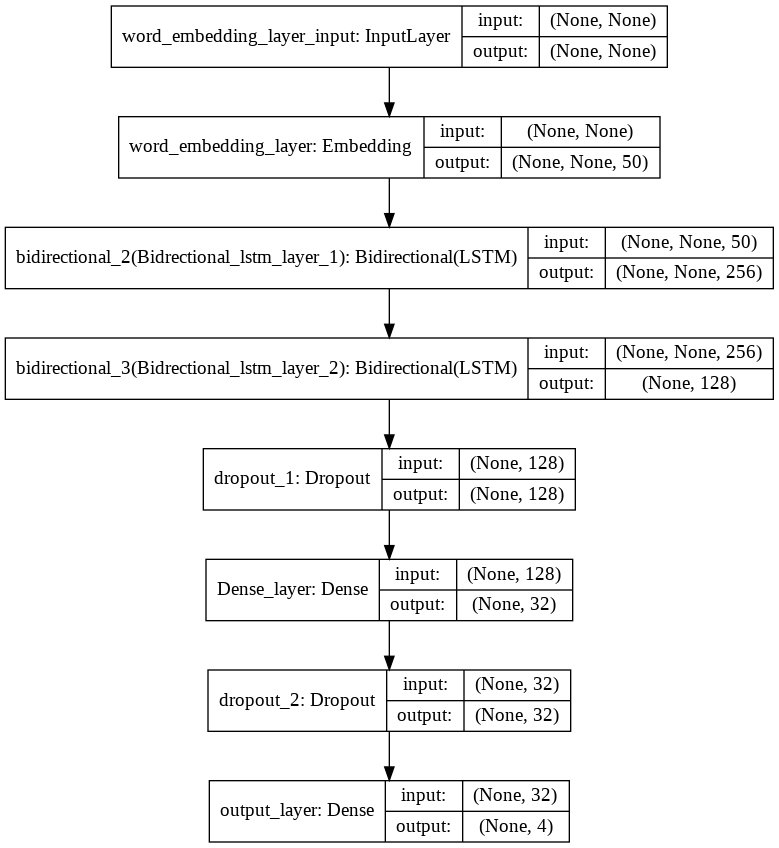

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Bi_lstm_1_architecture.png', show_shapes=True, show_layer_names=True)

### Saving the model

In [ ]:
model.save('Bi_lstm_1.h5')

- Epoch vs Accuracy Plot
- Epoch vs loss plot

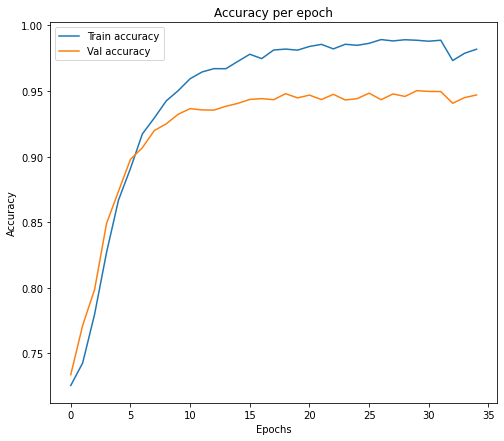

<Figure size 432x288 with 0 Axes>

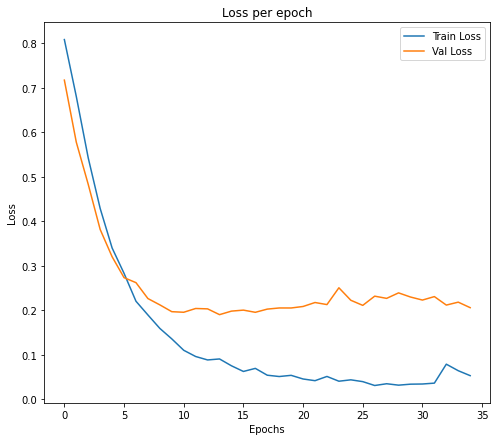

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(model_h.history['accuracy'])
plt.plot(model_h.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy per epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.savefig("Bi_lstm_1_acc.png")
plt.show()

plt.figure(figsize=(8,7))
plt.plot(model_h.history['loss'])
plt.plot(model_h.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss per epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.savefig("Bi_lstm_1_loss.png")
plt.show()

### Test accuracy

In [ ]:
score,acc = model.evaluate(X_test,y_test)
print("Accuracy at test set is : ",acc*100)

25413/25413 [==============================] - 78s 3ms/step
Accuracy at test set is :  73.68276119232178


### Predict

In [ ]:
def pred(features,target,model):
    y_pred= model.predict(features)
    y_pred= [np.argmax(pred, axis = -1) for pred in y_pred]   # categorical to single
    y_test= [np.argmax(t, axis = -1) for t in target]             # cat to sin
    
    def change_labels(y):
      # change the labels back to original categories
        for i in range(len(y)): 
            if y[i] == 0:
                y[i] = "unrelated"
            if y[i] == 1:
                y[i] = "disagree"
            if y[i] == 2:
                y[i] = "agree"
            if y[i] == 3:
                y[i] = "discuss"
        return y
    y_pred=change_labels(y_pred)
    y_test=change_labels(y_test)

    stance_list = y_pred

    stances_test = pd.read_csv('/content/drive/My Drive/641/'  + 'competition_test_stances.csv',index_col=False)
    df=stances_test.drop(['Stance'],axis=1)
    df['Stance']=stance_list
    df=df[['Headline','Body ID','Stance']]
    df.to_csv("Bi_lstm_1.csv",index=False)
    return df

In [ ]:
y_pred=pred(X_test,y_test,model)

In [ ]:
y_pred.iloc[10:20,:]

,Headline,Body ID,Stance
10,EXCLUSIVE: Apple To Unveil The Long-Awaited Re...,1964,discuss
11,50 foot crab : Is this a Crabzilla spotted in ...,2279,unrelated
12,Found! Missing Afghan Soldiers Spotted Trying ...,2312,unrelated
13,Obama Orders Fed To Adopt Euro Currency,2289,unrelated
14,Report: Three missing Afghan soldiers caught a...,1754,discuss
15,3-Boobed Woman a Fake,1618,disagree
16,"Fowler Falls For Fake Website, Makes Crazy Cla...",2173,unrelated
17,Hugh Hefner Dead? Fans Panic That Playboy Foun...,2320,unrelated
18,"Hong Kong's protesters are using the ""hands up...",2183,unrelated
19,TV show tricks chronic catcallers into harassi...,486,unrelated


### Model 2 - Bi lstm 
- LSTM with same params as Bi-LSTM

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=Dimensions_embedding,
                          weights = [embedding_matrix], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
model2.add(LSTM(128, return_sequences=True, name='lstm_layer_1'))
model2.add(LSTM(64, return_sequences=False, name='lstm_layer_2'))

model2.add(Dropout(rate=0.4, name='dropout_1'))
model2.add(Dense(32,activation='relu', name='Dense_layer'))

model2.add(Dropout(rate=0.2, name='dropout_2'))

model2.add(Dense(4, activation='softmax', name='output_layer'))

In [ ]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 128)         91648     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                

## compiling the model

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
              metrics=['accuracy'])

In [ ]:
model2_h = model2.fit(X_train, y_train,batch_size=256,epochs=35,validation_data=(X_val, y_val))

Train on 39977 samples, validate on 9995 samples
Epoch 1/35
39977/39977 [==============================] - 102s 3ms/step - loss: 0.8309 - accuracy: 0.7245 - val_loss: 0.8027 - val_accuracy: 0.7337
Epoch 2/35
39977/39977 [==============================] - 100s 2ms/step - loss: 0.7997 - accuracy: 0.7307 - val_loss: 0.7871 - val_accuracy: 0.7337
Epoch 3/35
39977/39977 [==============================] - 101s 3ms/step - loss: 0.7904 - accuracy: 0.7307 - val_loss: 0.7452 - val_accuracy: 0.7404
Epoch 4/35
39977/39977 [==============================] - 102s 3ms/step - loss: 0.7581 - accuracy: 0.7372 - val_loss: 0.7191 - val_accuracy: 0.7623
Epoch 5/35
39977/39977 [==============================] - 100s 3ms/step - loss: 0.6923 - accuracy: 0.7642 - val_loss: 0.6225 - val_accuracy: 0.7801
Epoch 6/35
39977/39977 [==============================] - 101s 3ms/step - loss: 0.6072 - accuracy: 0.7843 - val_loss: 0.5681 - val_accuracy: 0.7911
Epoch 7/35
39977/39977 [==============================] - 102s 

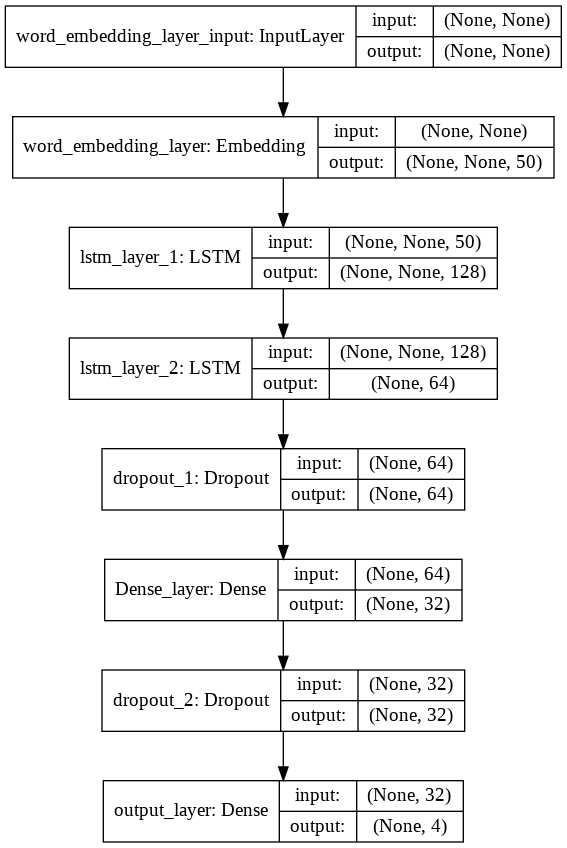

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='Lstm_2_architecture.png', show_shapes=True, show_layer_names=True)

## saving the model

In [ ]:
model2.save('Lstm_2.h5')

- Epoch vs Accuracy Plot
- Epoch vs loss plot

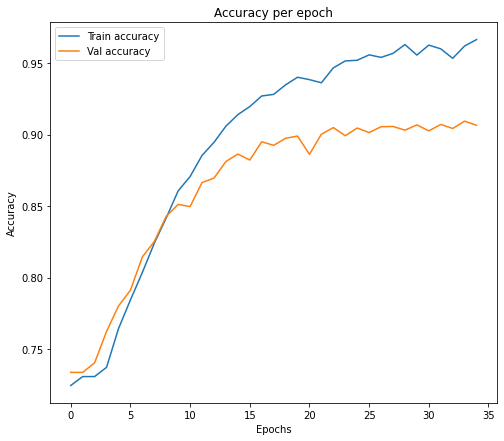

<Figure size 432x288 with 0 Axes>

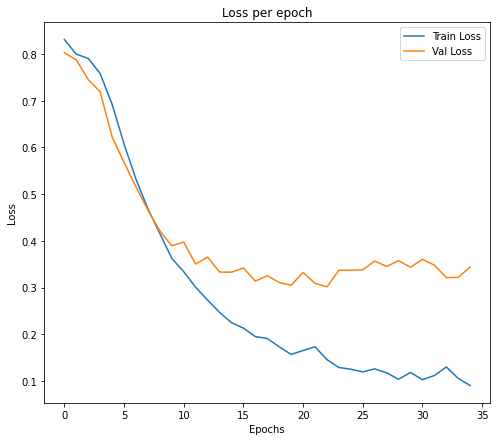

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,7))
plt.plot(model2_h.history['accuracy'])
plt.plot(model2_h.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy per epoch')
plt.legend(['Train accuracy', 'Val accuracy'])
plt.savefig("Lstm_2_acc.png")
plt.show()

plt.figure(figsize=(8,7))
plt.plot(model2_h.history['loss'])
plt.plot(model2_h.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss per epoch')
plt.legend(['Train Loss', 'Val Loss'])
plt.savefig("Lstm_2_loss.png")
plt.show()


## Test accuracy

In [ ]:
score2,acc2 = model2.evaluate(X_test,y_test)
print("Accuracy at test set is : ",acc2*100)

25413/25413 [==============================] - 42s 2ms/step
Accuracy at test set is :  67.2608494758606


## Predict

In [ ]:
def pred2(features,target,model2):
    y_pred= model2.predict(features)
    y_pred= [np.argmax(pred, axis = -1) for pred in y_pred]   # categorical to single
    y_test= [np.argmax(t, axis = -1) for t in target]             # cat to sin
    
    def change_labels(y):
      # change the labels back to original categories
        for i in range(len(y)): 
            if y[i] == 0:
                y[i] = "unrelated"
            if y[i] == 1:
                y[i] = "disagree"
            if y[i] == 2:
                y[i] = "agree"
            if y[i] == 3:
                y[i] = "discuss"
        return y
    y_pred=change_labels(y_pred)
    y_test=change_labels(y_test)

    stance_list = y_pred
    body_id = []
    headline = []
    
    stances_test = pd.read_csv('/content/drive/My Drive/641/'  + 'competition_test_stances.csv',index_col=False)
    df=stances_test.drop(['Stance'],axis=1)
    df['Stance']=stance_list
    df=df[['Headline','Body ID','Stance']]
    df.to_csv("Lstm_2.csv",index=False)
    return df

In [ ]:
y_pred2=pred2(X_test,y_test,model2)

In [ ]:
y_pred2.iloc[10:20,:]

,Headline,Body ID,Stance
10,EXCLUSIVE: Apple To Unveil The Long-Awaited Re...,1964,discuss
11,50 foot crab : Is this a Crabzilla spotted in ...,2279,unrelated
12,Found! Missing Afghan Soldiers Spotted Trying ...,2312,unrelated
13,Obama Orders Fed To Adopt Euro Currency,2289,disagree
14,Report: Three missing Afghan soldiers caught a...,1754,unrelated
15,3-Boobed Woman a Fake,1618,agree
16,"Fowler Falls For Fake Website, Makes Crazy Cla...",2173,unrelated
17,Hugh Hefner Dead? Fans Panic That Playboy Foun...,2320,unrelated
18,"Hong Kong's protesters are using the ""hands up...",2183,unrelated
19,TV show tricks chronic catcallers into harassi...,486,unrelated
